Carregando os dados treinamento e teste

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt 
import seaborn as sns 
import xgboost as xgb
from scipy import stats
from scipy.stats import norm, skew
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error,accuracy_score

from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingRegressor, RandomForestClassifier
from lightgbm import LGBMRegressor
from sklearn.pipeline import make_pipeline
from mlxtend.regressor import StackingCVRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from pandas.api.types import CategoricalDtype
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV, Lasso, Ridge
import os
print(os.listdir('input'))
train = pd.read_csv('input2/train.csv')
test = pd.read_csv('input2/test.csv')

all_data = pd.concat((train, test)).reset_index(drop=True)

"""
trainFilter = all_data.copy()
categorical_cols = [cname for cname in trainFilter.columns if
                    trainFilter[cname].nunique() > 10 and trainFilter[cname].dtype == "object"]
categorical_cols

"""
#ordered_CentralAir = {'CentralAir': {'Y':1, 'N':0}}
#all_data.replace(ordered_CentralAir, inplace=True)
#all_data['CentralAir']
#dados = pd.DataFrame(all_data['Neighborhood'])
#dados['Neighborhood'].value_counts()
#dados['Neighborhood'].astype('category')

['data_description.txt', 'test.csv', 'train.csv']


'\ntrainFilter = all_data.copy()\ncategorical_cols = [cname for cname in trainFilter.columns if\n                    trainFilter[cname].nunique() > 10 and trainFilter[cname].dtype == "object"]\ncategorical_cols\n\n'

1.1 - Seleção das Variáveis
São um total de 80 variáveis de predição e mais 1 que é a variável alvo.
O modelo que vamos utilizar é o aprendizado supervisionado de regressão porque no final queremos predizer o preço das casas.
Treinamento: 1460 linhas e 81 colunas
test: 1459 linhas e 80 colunas
Total: 2919 linhas e 81 colunas
1.2 Será feita uma análise variável a variável. Primeiro buscando iniciar o trabalho iremos verificar os valores missing para entender como tratar cada variáveis.
1.2.1 - Primeira variável com mais missing é a PoolQC.
        Foi verificado que só tem 7 linhas preenchidas no treina e 3 no teste. E mesmo essas linhas que são preenchidas não tem correlação forte, se transformado os valores em uma escala dummie.

Consulta para verificação missing data:
#missing data
total = all_data.isnull().sum().sort_values(ascending=False)
percent = (all_data.isnull().sum()/all_data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(25)

train.Alley.unique() #lista os valores distintos apresentados na coluna informada.

PoolNull = train[train.PoolQC.notnull()] #codigo para retornar somente os não vazios.

PoolNull = PoolNull[['PoolQC', 'SalePrice']].sort_values('SalePrice',ascending=True) # código para ordernar pelo preço e fazer uma pré analise dos dados preenchidos.

PoolNull = pd.get_dummies(PoolNull) #transformar valores categoricos em novas colunas 0/1.

Código para gerar o mapa de calor e analisar correlação entre variável alvo (preço e PoolQC).

plt.figure(figsize=(20,12))
sns.heatmap(PoolNull.corr(),cmap='coolwarm',annot = True)
plt.show()

plt.scatter(x= 'MSZoning_RM', y='SalePrice', data = PoolNull)

plt.figure(figsize=(16,8))
sns.boxplot(x='GrLivArea',y='SalePrice',data=train)
plt.show()

In [2]:
# REMOVER COLUNA PoolQC e MiscFeature (muitos missing) e Utilities só tem uma linha com valor diferente.
all_data = all_data.drop(['PoolQC', 'MiscFeature','Utilities'], 1).copy()

"""Preencher na coluna Alley com None.Na documentação explica 
que quando não tem é porque não tem acesso."""
all_data[['Alley','Fence','FireplaceQu','GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
          'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 
          'BsmtFinType2','MasVnrType']] = all_data[['Alley','Fence','FireplaceQu','GarageType', 
                                                    'GarageFinish', 'GarageQual', 'GarageCond', 
                                                    'BsmtQual', 'BsmtCond', 'BsmtExposure', 
                                                    'BsmtFinType1', 'BsmtFinType2',
                                                    'MasVnrType']].fillna("None")

#QUANDO NAO TEM GARAGE NÃO TEM AREA O OU CARROS PREENCHE COM 0
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars','BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea'):
    all_data[col] = all_data[col].fillna(0)

#Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood 
#PREENCHE COM A MEDIA DO BAIRRO
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

#PREENCHE COM O VALOR MAIS COMUM
# PREENCHENDO COM O VALOR MAIS COMUM QUE É RL
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])
# PREENCHENDO COM O VALOR MAIS COMUM QUE É SBrkr
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])
# PREENCHENDO COM O VALOR MAIS COMUM QUE É TA
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['YrSold'] = all_data['YrSold'].fillna(all_data['YrSold'].mode()[0])
all_data['YearRemodAdd'] = all_data['YearRemodAdd'].fillna(all_data['YearRemodAdd'].mode()[0])
#all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])
all_data["Functional"] = all_data["Functional"].fillna(all_data['Functional'].mode()[0])
all_data["Exterior2nd"] = all_data["Exterior2nd"].fillna(all_data['Exterior2nd'].mode()[0])
''' 
# a opção de substituir por o valor mais frequente é melhor do que essa opção abaixo de substituir
os valores inseridos.
ext_other = [
    'Stone',
    'AsphShn',
    'Other',
    'CBlock',
    'ImStucc',
    'Brk Cmn'
]
all_data['Exterior2nd'] = all_data['Exterior2nd'].apply(lambda x: 'Other' if x in ext_other else x)
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna('Other')
'''
saletype_other = [
    'ConLD',
    'ConLw',
    'ConLI',
    'CWD',
    'Oth',
    'Con'
]

all_data['SaleType'] = all_data['SaleType'].apply(lambda x: x if x not in saletype_other else 'Other')
all_data['SaleType'] = all_data['SaleType'].fillna('Other')
#Transforming some numerical variables that are really categorical
#MSSubClass=The building class
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)

#Changing OverallCond into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].astype(str)

#CRIANDO NOVAS VARIAVEIS (MELHOROU BEM COM NOVA VARIAVEL)
all_data['IsNew'] = np.where(all_data['YrSold'] == all_data['YearBuilt'], 1, 0)
all_data['Remod'] = np.where(all_data['YearBuilt'] == all_data['YearRemodAdd'], 0, 1)
all_data['Age'] = all_data['YrSold'] - all_data['YearRemodAdd']
all_data['Age'] = all_data['Age'].apply(lambda x: 0 if x < 0 
                                        else x)

#all_data['TotalPorchSF'] = all_data['OpenPorchSF'] + all_data['EnclosedPorch'] + all_data['3SsnPorch'] + all_data['ScreenPorch']

#all_data['TotalSqFeet'] = all_data['GrLivArea'] + all_data['TotalBsmtSF']
"""
all_data['NeighRich'] = all_data['Neighborhood'].apply(lambda x: 
                                                       2 if x in ['StoneBr', 'NridgHt', 'NoRidge'] else
                                                       1 if x not in ['MeadowV', 'IDOTRR', 'BrDale', 'StoneBr', 'NridgHt', 'NoRidge'] 
                                                       else 0)
                                                       """
#Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

# Adding total sqfootage feature 
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']
all_data['TotBathrooms'] = all_data['FullBath'] + (all_data['HalfBath']*0.5) + all_data['BsmtFullBath'] + (all_data['BsmtHalfBath']*0.5)

#arrumar ano que foi imputado errado
all_data.loc[all_data["GarageYrBlt"] == 2207, "GarageYrBlt"] = 2007

#DELETAR OUTLIER
all_data = all_data.drop(all_data[(all_data['GrLivArea']>4000) & (all_data['SalePrice']<300000)].index).copy()
all_data = all_data.drop(all_data[(all_data['GarageArea']>1230) & (all_data['SalePrice']<300000)].index).copy()
all_data = all_data.drop(all_data[(all_data['TotRmsAbvGrd']>13) & (all_data['SalePrice']<300000)].index).copy()
all_data = all_data.drop(all_data[(all_data['MasVnrArea']>1590) & (all_data['SalePrice']<300000)].index).copy()
#all_data = all_data.drop(all_data[(all_data['SalePrice']>700000)].index).copy()
#all_data = all_data.drop(all_data[(all_data['TotalBsmtSF']>5000)].index).copy()
#all_data = all_data.drop(all_data[(all_data['LotFrontage']>300)].index).copy()
'''Tentei remover PORQUE A CORRELACAO COM GarageYrBlt é acima de 80%, porém sem ela
o resultado ficou pior.
#all_data = all_data.drop(['YearBuilt'], 1).copy()
'''
#MAPEAMENTO DE VARIAVEL CATEGORICA PARA ORDINAL - PIOROU O RESULTADO QUANDO ALTERADO
#ordered_HeatingQC = {'HeatingQC': {'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}}
#all_data.replace(ordered_HeatingQC, inplace=True)
#ordered_CentralAir = {'CentralAir': {'Y':1, 'N':0}}
#all_data.replace(ordered_CentralAir, inplace=True)
#ordered_PavedDrive = {'PavedDrive': {'N':0, 'P':1, 'Y':2}}
#all_data.replace(ordered_PavedDrive, inplace=True)
#ordered_Functional = {'Functional': {'Sal':0, 'Sev':1, 'Maj2':2, 'Maj1':3, 'Mod':4, 
#                                     'Min2':5, 'Min1':6, 'Typ':7}}
#all_data.replace(ordered_Functional, inplace=True)

#REMOVER CORRELACOES MUITO FORTES ENTRE OUTRAS VARIAVEIS - ANALISADO VIA HEATMAP
all_data = all_data.drop(['GarageArea', 'MSSubClass','Exterior2nd','BsmtFinType2',
                          'BsmtExposure','BsmtQual','BsmtCond','GarageType','GarageFinish','GarageQual','GarageCond'], 1).copy()

#TRANSFORMAR AS VARIAVEIS CATEGORICAS EM 1/0
all_data = pd.get_dummies(all_data)



In [3]:
"""ANALISE DAS VARIAVEIS DE MAIOR IMPORTANCIA 
all_data_y = all_data.loc[0:1459,'SalePrice']
all_data_classifier = all_data.loc[0:1459].drop(['SalePrice'], 1).copy()
S_train, S_test, Sy_train, Sy_test = train_test_split(all_data_classifier, all_data_y, test_size=0.3) 
clf=RandomForestClassifier(n_estimators=100)
clf.fit(S_train,Sy_train)
y_pred=clf.predict(S_test)
print("MSE:",mean_squared_error(Sy_test, y_pred))
feature_imp = pd.Series(clf.feature_importances_,index=all_data_classifier.columns).sort_values(ascending=False)
sns.set(rc={'figure.figsize':(12,9)})
sns.barplot(x=feature_imp[1:20], y=feature_imp[1:20].index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()
"""


'ANALISE DAS VARIAVEIS DE MAIOR IMPORTANCIA \nall_data_y = all_data.loc[0:1459,\'SalePrice\']\nall_data_classifier = all_data.loc[0:1459].drop([\'SalePrice\'], 1).copy()\nS_train, S_test, Sy_train, Sy_test = train_test_split(all_data_classifier, all_data_y, test_size=0.3) \nclf=RandomForestClassifier(n_estimators=100)\nclf.fit(S_train,Sy_train)\ny_pred=clf.predict(S_test)\nprint("MSE:",mean_squared_error(Sy_test, y_pred))\nfeature_imp = pd.Series(clf.feature_importances_,index=all_data_classifier.columns).sort_values(ascending=False)\nsns.set(rc={\'figure.figsize\':(12,9)})\nsns.barplot(x=feature_imp[1:20], y=feature_imp[1:20].index)\nplt.xlabel(\'Feature Importance Score\')\nplt.ylabel(\'Features\')\nplt.title("Visualizing Important Features")\nplt.legend()\nplt.show()\n'

1.2 PADRONIZAÇÃO DOS DADOS
    PRIMEIRO PADRONIZAR VARIÁVEL ALVO (SalePrice)

In [4]:
#VERIFICACAO DA NECESSIDADE DE PADRONIZAR VARIÁVEL ALVO
"""
sns.distplot(train['SalePrice'] , fit=norm);
# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

plt.hist(train['SalePrice'], bins=10, color='mediumpurple',alpha=0.5)
plt.title('Sale price distribution before normalization',weight='bold', fontsize=18)

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show() 

plt.figure(figsize=(7, 6))
sns.boxplot(y='SalePrice', data=train)

"""
#all_data['Street']
#plt.scatter(x='TotalBsmtSF',y='1stFlrSF',data=all_data)


"\nsns.distplot(train['SalePrice'] , fit=norm);\n# Get the fitted parameters used by the function\n(mu, sigma) = norm.fit(train['SalePrice'])\nprint( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))\n\n#Now plot the distribution\nplt.legend(['Normal dist. ($\\mu=$ {:.2f} and $\\sigma=$ {:.2f} )'.format(mu, sigma)],\n            loc='best')\nplt.ylabel('Frequency')\nplt.title('SalePrice distribution')\n\nplt.hist(train['SalePrice'], bins=10, color='mediumpurple',alpha=0.5)\nplt.title('Sale price distribution before normalization',weight='bold', fontsize=18)\n\n#Get also the QQ-plot\nfig = plt.figure()\nres = stats.probplot(train['SalePrice'], plot=plt)\nplt.show() \n\nplt.figure(figsize=(7, 6))\nsns.boxplot(y='SalePrice', data=train)\n\n"

In [5]:
"""
#REDUÇÃO DAS DIMENSÕES - PIOROU MUITO AS PREDIÇÕES
all_data2 = all_data.copy()
y = all_data['SalePrice']
all_data2 = all_data2.drop('SalePrice', axis=1)
pca = PCA(0.99) #pode apontar o nro de variaveis ou variancia. Aqui irei aplicar variancia.
all_data_lowDimension = pca.fit_transform(all_data2)
new_data3 = pd.DataFrame(all_data_lowDimension, columns=['col1','col2','col3','col4','col5'])
new_data3['SalePrice'] = y
new_data3
train = new_data3[(new_data3['SalePrice'].notnull() == True)]
test = new_data3[(new_data3['SalePrice'].notnull() == False)]
if 'SalePrice' in test.columns:
    test.drop('SalePrice', axis=1)
"""
#SEM REDUZIR DIMENSÕES
train = all_data[(all_data['SalePrice'].notnull() == True)]
test = all_data[(all_data['SalePrice'].notnull() == False)]
#train = train.reset_index(drop=True)
#test = test.reset_index(drop=True)

if 'SalePrice' in test.columns:
    test = test.drop('SalePrice', axis=1)

if 'Id' in test.columns:
    testId = test['Id']
    test = test.drop('Id', axis=1)


In [6]:
#além da variável SalePrice também foi feita a padronização das variáveis
#train = all_data[(all_data['SalePrice'].notnull() == True)]
#test = all_data[(all_data['SalePrice'].notnull() == False)]
train = np.log1p(train).copy()
test = np.log1p(test).copy()
if 'Id' in train.columns:
    train = train.drop('Id', axis=1)

In [78]:
#VERIFICACAO DAS VARIÁVEIS MAIS CORRELACIONADAS COM O PREÇO DE VENDA
"""
k = 20 #number of variables for heatmap
plt.figure(figsize=(18,10))
# LINHAS ABAIXO É PARA PEGAR DE 20 EM 20 E VERIFICAR CORRELAÇÃO DAS VARIAVEIS
#train20 = train.copy()
#train20 = train20.drop(cols,1)
#train20['SalePrice'] = train['SalePrice']
corrmat = train.corr()
# picking the top 15 correlated features nsmallest 
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

# SELEÇÃO DAS VARIÁVEIS
corrmat = train.corr()
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
train = train[cols]
cols = cols.drop('SalePrice')
test = test[cols]
"""
"""
colstrain = ['SalePrice','OverallQual', 'TotalSF', 'GrLivArea', 'GarageCars',
        'TotalBsmtSF', 'FullBath', 'BsmtQual_Ex',
       'TotRmsAbvGrd', 'YearBuilt', 'YearRemodAdd',
             'Foundation_PConc','MasVnrArea', 'Fireplaces','ExterQual_Ex','BsmtFinType1_GLQ']
colstest = ['OverallQual', 'TotalSF', 'GrLivArea', 'GarageCars',
        'TotalBsmtSF', 'FullBath', 'BsmtQual_Ex',
       'TotRmsAbvGrd', 'YearBuilt', 'YearRemodAdd',
            'Foundation_PConc', 'MasVnrArea', 'Fireplaces','ExterQual_Ex','BsmtFinType1_GLQ']
train = train[colstrain]
test = test[colstest]
"""

"\ncolstrain = ['SalePrice','OverallQual', 'TotalSF', 'GrLivArea', 'GarageCars',\n        'TotalBsmtSF', 'FullBath', 'BsmtQual_Ex',\n       'TotRmsAbvGrd', 'YearBuilt', 'YearRemodAdd',\n             'Foundation_PConc','MasVnrArea', 'Fireplaces','ExterQual_Ex','BsmtFinType1_GLQ']\ncolstest = ['OverallQual', 'TotalSF', 'GrLivArea', 'GarageCars',\n        'TotalBsmtSF', 'FullBath', 'BsmtQual_Ex',\n       'TotRmsAbvGrd', 'YearBuilt', 'YearRemodAdd',\n            'Foundation_PConc', 'MasVnrArea', 'Fireplaces','ExterQual_Ex','BsmtFinType1_GLQ']\ntrain = train[colstrain]\ntest = test[colstest]\n"

In [7]:
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

def cv_rmse(model, train=train):
    if 'Id' in train.columns:
        train = train.drop('Id', axis=1)
    if 'SalePrice' in train.columns:
        y = train['SalePrice']
        train = train.drop('SalePrice', axis=1)
    rmse = np.sqrt(-cross_val_score(model, train, y, scoring="neg_mean_squared_error", cv=kfolds))
    return (rmse)
"""
TECNICA DE MELHORAR PARAMETROS NÃO SEI SE FUNCIONA MUITO BEM
params = {"objective":"reg:squarederror",'colsample_bytree': 0.3,'learning_rate': 0.04,
                'max_depth': 3, 'random_state': 101,  'n_jobs':2}
data_dmatrix = xgb.DMatrix(data=train.drop('SalePrice', axis=1),label=train['SalePrice'])
cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=10,
                    num_boost_round=500,early_stopping_rounds=5,metrics="rmse", 
                    as_pandas=True, seed=123)
cv_results.head()
print('Best number of trees = {}'.format(cv_results.shape[0]))
cv_results.tail()
"""

'\nTECNICA DE MELHORAR PARAMETROS NÃO SEI SE FUNCIONA MUITO BEM\nparams = {"objective":"reg:squarederror",\'colsample_bytree\': 0.3,\'learning_rate\': 0.04,\n                \'max_depth\': 3, \'random_state\': 101,  \'n_jobs\':2}\ndata_dmatrix = xgb.DMatrix(data=train.drop(\'SalePrice\', axis=1),label=train[\'SalePrice\'])\ncv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=10,\n                    num_boost_round=500,early_stopping_rounds=5,metrics="rmse", \n                    as_pandas=True, seed=123)\ncv_results.head()\nprint(\'Best number of trees = {}\'.format(cv_results.shape[0]))\ncv_results.tail()\n'

MAE: 0.07886932792281802
MSE: 0.012893519818397679
RMSE: 0.11354963592366854


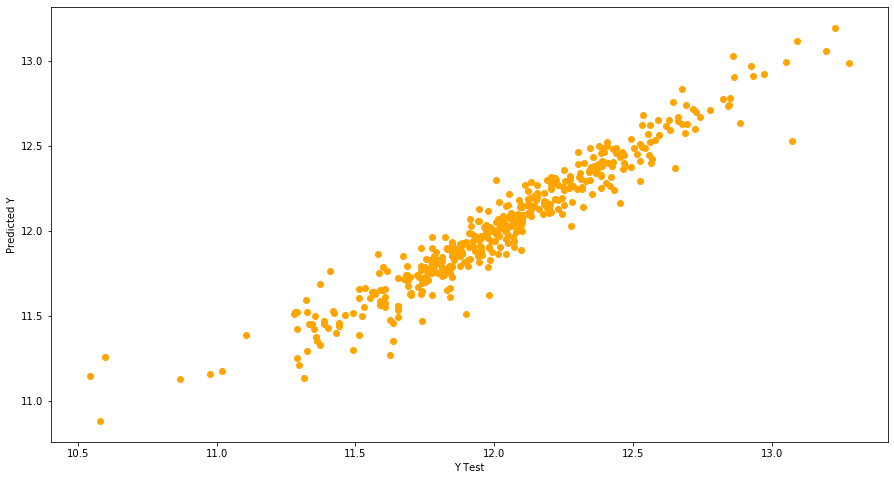

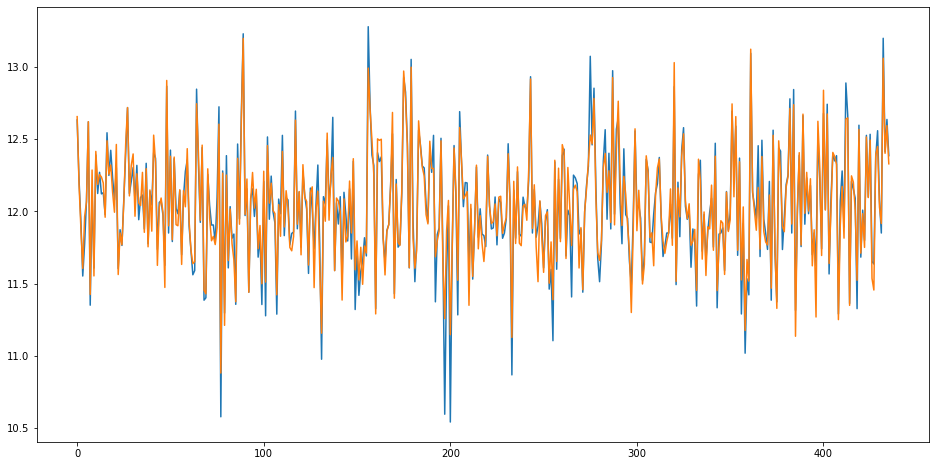

In [8]:
#DIVISÃO DA AMOSTRA
X_train, X_test, y_train, y_test = train_test_split(train.drop('SalePrice', axis=1), 
                                                    train['SalePrice'], test_size=0.3, random_state=101)
# Define model
xgbbost =  xgb.XGBRegressor(objective ='reg:squarederror',
                                n_estimators=1800, 
                                learning_rate=0.04, n_jobs=2, max_depth=3,random_state=101)
""" mesmo resultado
xgboost = XGBRegressor(learning_rate=0.01,n_estimators=3460,
                                     max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:squarederror', nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00006)
"""
gbr = GradientBoostingRegressor(n_estimators=1600, learning_rate=0.034, max_depth=3,
                                max_features='sqrt', 
                                min_samples_leaf=15, loss='huber', random_state =42)                             

model = xgbbost
#modelKfold = gbr
# Preprocessing of training data, fit model 
#model.fit(X_train, y_train)

#Preprocessing of training data, fit model  stack_gen
# treinar os dados com separacao entre treino e teste
model.fit(X_train, y_train)

# Preprocessing of validation data, get predictions
preds = model.predict(X_test)
#y_test = np.expm1(y_test).copy() 
#preds = np.expm1(preds).copy() 
print('MAE:', mean_absolute_error(y_test, preds))
print('MSE:', mean_squared_error(y_test, preds))
print('RMSE:', np.sqrt(mean_squared_error(y_test, preds)))
#REALIZAÇAO DE CROSS-VALIDATION
#score = cv_rmse(model, train)
#print("RMSE-KFOLD: {:.4f} ({:.4f})\n".format(score.mean(), score.std()),  )

y_test.reset_index(inplace=True, drop=True)
plt.figure(figsize=(15,8))
plt.scatter(y_test,preds, c='orange')
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')
plt.show()
plt.figure(figsize=(16,8))
plt.plot(y_test,label ='Test')
plt.plot(preds, label = 'predict')
plt.show()


In [9]:
#TREINAR UTILIZANDO TODOS OS DADOS
if 'Id' in train.columns:
        train_all = train.drop('Id', axis=1)
if 'SalePrice' in train.columns:
    y = train['SalePrice']
    train_all = train.drop('SalePrice', axis=1)
model.fit(train_all, y)


XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.04, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=1800, n_jobs=2, num_parallel_tree=1,
             objective='reg:squarederror', random_state=101, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

In [2651]:
""" outros modelos com pior resultado e utilizando KFOLD
MAE: 13777.23667968824
MSE: 421996310.71645224
RMSE: 20542.548788221295
lightgbm = LGBMRegressor(objective='regression', 
                                       num_leaves=3,
                                       learning_rate=0.04, 
                                       n_estimators=3000,
                                       max_bin=200, 
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.2,
                                       feature_fraction_seed=7,
                                       verbose=-1,
                                       #min_data_in_leaf=2,
                                       #min_sum_hessian_in_leaf=11
                                       )

#ficou pior que o gbr sozinho
stack_gen = StackingCVRegressor(regressors=(gbr, xgboost),
                                meta_regressor=gbr,
                                use_features_in_secondary=True)
model.fit(np.array(X_train), np.array(y_train))
preds = model.predict(np.array(X_test))
score = cv_rmse(modelKfold, train)
print("RMSE-KFOLD: {:.4f} ({:.4f})\n".format(score.mean(), score.std()),  )

predkfold = np.expm1(modelKfold.predict(train.drop('SalePrice', axis=1)))
y = np.expm1(train['SalePrice'])
plt.figure(figsize=(15,8))
plt.scatter(y,predkfold, c='orange')
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')
plt.show()
plt.figure(figsize=(16,8))
plt.plot(y,label ='Test')
plt.plot(predkfold, label = 'predict')
plt.show()
"""

' outros modelos com pior resultado e utilizando KFOLD\nMAE: 13777.23667968824\nMSE: 421996310.71645224\nRMSE: 20542.548788221295\nlightgbm = LGBMRegressor(objective=\'regression\', \n                                       num_leaves=3,\n                                       learning_rate=0.04, \n                                       n_estimators=3000,\n                                       max_bin=200, \n                                       bagging_fraction=0.75,\n                                       bagging_freq=5, \n                                       bagging_seed=7,\n                                       feature_fraction=0.2,\n                                       feature_fraction_seed=7,\n                                       verbose=-1,\n                                       #min_data_in_leaf=2,\n                                       #min_sum_hessian_in_leaf=11\n                                       )\n\n#ficou pior que o gbr sozinho\nstack_gen = StackingCVRegress

In [2652]:
    """ COMO BUSCAR OS MELHORES PARAMETROS
    model = GradientBoostingRegressor()
    parameters = {'learning_rate': [0.01,0.02,0.03],
                  'subsample'    : [0.9, 0.5, 0.2],
                  'n_estimators' : [100,500,1000],
                  'max_depth'    : [4,6,8]
                 }
    grid = GridSearchCV(estimator=model, param_grid = parameters, cv = 2, n_jobs=-1)
    grid.fit(X_train, y_train)

    # Results from Grid Search
    print("\n========================================================")
    print(" Results from Grid Search " )
    print("========================================================")
    print("\n The best estimator across ALL searched params:\n",
          grid.best_estimator_)
    print("\n The best score across ALL searched params:\n",
          grid.best_score_)
    print("\n The best parameters across ALL searched params:\n",
          grid.best_params_)
    print("\n ========================================================")
    

params = [{'loss': ['ls','huber'], 'learning_rate': [0.05, 0.07, 0.15, 0.2], 'n_estimators': [200],'max_depth': [5], 'subsample' : [1] },
          {'loss': ['ls','huber'], 'n_estimators': [1500,1400,1480,3000,100],'learning_rate': [0.051,0.04,0.51,0.52], 
          'max_depth': [3,4], 'subsample' : [1,0.99,0.9] }]

gs = GridSearchCV(estimator = gbr, param_grid = params, 
                  scoring = 'explained_variance', cv = 10, n_jobs = 2) 
#-1 usa total recurso. n_jos numero de cpu utilizacao

gs.fit(X_train,y_train)
print("Best Score : ", gs.best_score_)
print("Best Parameters : ",gs.best_params_)
"""

' COMO BUSCAR OS MELHORES PARAMETROS\nmodel = GradientBoostingRegressor()\nparameters = {\'learning_rate\': [0.01,0.02,0.03],\n              \'subsample\'    : [0.9, 0.5, 0.2],\n              \'n_estimators\' : [100,500,1000],\n              \'max_depth\'    : [4,6,8]\n             }\ngrid = GridSearchCV(estimator=model, param_grid = parameters, cv = 2, n_jobs=-1)\ngrid.fit(X_train, y_train)\n\n# Results from Grid Search\nprint("\n========================================================")\nprint(" Results from Grid Search " )\nprint("========================================================")\nprint("\n The best estimator across ALL searched params:\n",\n      grid.best_estimator_)\nprint("\n The best score across ALL searched params:\n",\n      grid.best_score_)\nprint("\n The best parameters across ALL searched params:\n",\n      grid.best_params_)\nprint("\n ========================================================")\n\n\nparams = [{\'loss\': [\'ls\',\'huber\'], \'learning_rate\': [0.

In [79]:
"LASSO"
regLasso = Lasso(alpha=0.000097)
regLasso.fit(train_all, y)
#print('Lasso Regression: R^2 score on training set', regLasso.score(train_all, y)*100)
#print('Lasso Regression: R^2 score on test set', regLasso.score(X_test, y_test)*100)
print('RMSE:',np.sqrt(mean_squared_error(y_test, regLasso.predict(X_test))))

RMSE: 0.0983344382432038


CV-alpha_ 9.7e-05
[9.7e-05, 0.0001, 0.00011514, 0.00013257, 0.00015264, 0.00017575, 0.00020236, 0.000233, 0.00026827, 0.00030888, 0.00035565, 0.00040949, 0.00047149, 0.00054287, 0.00062506, 0.00071969, 0.00082864, 0.0009541, 0.00109854, 0.00126486, 0.00145635, 0.00167683, 0.0019307, 0.002223, 0.00255955, 0.00294705, 0.00339322, 0.00390694, 0.00449843, 0.00517947, 0.00596362, 0.00686649, 0.00790604, 0.00910298, 0.01048113, 0.01206793, 0.01389495, 0.01599859, 0.0184207, 0.02120951, 0.02442053, 0.02811769, 0.03237458, 0.03727594, 0.04291934, 0.04941713, 0.05689866, 0.06551286, 0.0754312, 0.08685114, 0.1]


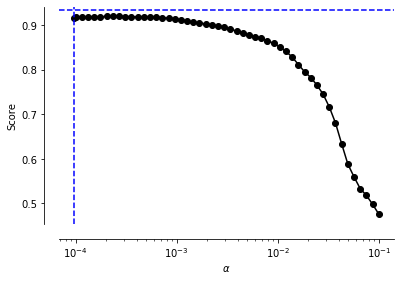

In [91]:
#alphas = np.logspace(-4, -1, 50)
alphas = [ 0.000097, 0.0001    , 0.00011514, 0.00013257, 0.00015264, 0.00017575,
       0.00020236, 0.000233  , 0.00026827, 0.00030888, 0.00035565,
       0.00040949, 0.00047149, 0.00054287, 0.00062506, 0.00071969,
       0.00082864, 0.0009541 , 0.00109854, 0.00126486, 0.00145635,
       0.00167683, 0.0019307 , 0.002223  , 0.00255955, 0.00294705,
       0.00339322, 0.00390694, 0.00449843, 0.00517947, 0.00596362,
       0.00686649, 0.00790604, 0.00910298, 0.01048113, 0.01206793,
       0.01389495, 0.01599859, 0.0184207 , 0.02120951, 0.02442053,
       0.02811769, 0.03237458, 0.03727594, 0.04291934, 0.04941713,
       0.05689866, 0.06551286, 0.0754312 , 0.08685114, 0.1       ]
scores = np.empty_like(alphas)
for i,a in enumerate(alphas):
    lasso = Lasso()
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    scores[i] = lasso.score(X_test, y_test)
    #print(a, lasso.coef_)

lassocv = LassoCV(alphas = alphas, normalize = True)
lassocv.fit(train_all, y)
lassocv_score = lassocv.score(train_all, y)
lassocv_alpha = lassocv.alpha_
print('CV-alpha_', lassocv.alpha_)
#print('CV', lassocv.coef_)
print(alphas)

plt.plot(alphas, scores, '-ko')
plt.axhline(lassocv_score, color='b', ls='--')
plt.axvline(lassocv_alpha, color='b', ls='--')
plt.xlabel(r'$\alpha$')
plt.ylabel('Score')
plt.xscale('log')
sns.despine(offset=15)



In [86]:

"""
lambdas = (0.001, 0.01, 0.1, 0.5, 1, 2, 10)
l_num = 7
pred_num = X_train.shape[1]

# prepare data for enumerate
coeff_a = np.zeros((l_num, pred_num))
train_r_squared = np.zeros(l_num)
test_r_squared = np.zeros(l_num)

# enumerate through lambdas with index and i
for ind, i in enumerate(lambdas):    
    reg = Lasso(alpha = i)
    reg.fit(X_train, y_train)

    coeff_a[ind,:] = reg.coef_
    train_r_squared[ind] = reg.score(X_train, y_train)
    test_r_squared[ind] = reg.score(X_test, y_test)

df_lam = pd.DataFrame(train_r_squared*100, columns=['R_squared'])
df_lam['lambda'] = (lambdas)
# returns the index of the row where column has maximum value.
df_lam.loc[df_lam['R_squared'].idxmax()]

# Coefficients of best model
reg_best = Lasso(alpha = 0.001)
reg_best.fit(X_train, y_train)
reg_best.coef_

print('RMSE:',np.sqrt(mean_squared_error(y_test, reg_best.predict(X_test))))
"""
"""
plt.figure(figsize=(18, 8))
plt.plot(train_r_squared, 'bo-', label=r'$R^2$ Training set', color="darkblue", alpha=0.6, linewidth=3)
plt.plot(test_r_squared, 'bo-', label=r'$R^2$ Test set', color="darkred", alpha=0.6, linewidth=3)
plt.xlabel('Lamda index'); plt.ylabel(r'$R^2$')
plt.xlim(0, 6)
plt.title(r'Evaluate lasso regression with lamdas: 0 = 0.001, 1= 0.01, 2 = 0.1, 3 = 0.5, 4= 1, 5= 2, 6 = 10')
plt.legend(loc='best')
plt.grid()
"""
alphas = np.logspace(-4, -1, 50)
alphas

array([0.0001    , 0.00011514, 0.00013257, 0.00015264, 0.00017575,
       0.00020236, 0.000233  , 0.00026827, 0.00030888, 0.00035565,
       0.00040949, 0.00047149, 0.00054287, 0.00062506, 0.00071969,
       0.00082864, 0.0009541 , 0.00109854, 0.00126486, 0.00145635,
       0.00167683, 0.0019307 , 0.002223  , 0.00255955, 0.00294705,
       0.00339322, 0.00390694, 0.00449843, 0.00517947, 0.00596362,
       0.00686649, 0.00790604, 0.00910298, 0.01048113, 0.01206793,
       0.01389495, 0.01599859, 0.0184207 , 0.02120951, 0.02442053,
       0.02811769, 0.03237458, 0.03727594, 0.04291934, 0.04941713,
       0.05689866, 0.06551286, 0.0754312 , 0.08685114, 0.1       ])

In [139]:


"""
#alphas = 10**np.linspace(6,-2,50)*0.5
alphas = 10**np.linspace(6,-2,50)*0.5
lasso = Lasso(max_iter=10000, normalize=True)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(train_all, y)
    coefs.append(lasso.coef_)
    
np.shape(coefs)


ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')

lassocv = LassoCV(alphas=None, cv=10, max_iter=100000, normalize=True)
lassocv.fit(X_train, y_train)
lasso.set_params(alpha=lassocv.alpha_)
print("Alpha=", lassocv.alpha_)
lasso.fit(X_train, y_train)
print("RMSE = ",np.sqrt(mean_squared_error(y_test, lasso.predict(X_test))))
print("best model coefficients:")
pd.Series(lasso.coef_, index=train_all.columns)

"RIDGE"
ridgecv = RidgeCV(alphas=alphas, normalize=True)
ridgecv.fit(X_train, y_train)
print("Alpha=", ridgecv.alpha_)
ridge6 = Ridge(alpha=ridgecv.alpha_, normalize=True)
ridge6.fit(X_train, y_train)
print("mse = ",mean_squared_error(y_test, ridge6.predict(X_test)))
print("best model coefficients:")
pd.Series(ridge6.coef_, index=X_test.columns)


    parameters = {'learning_rate': [0.01,0.02,0.03],
                  'subsample'    : [0.9, 0.5, 0.2],
                  'n_estimators' : [100,500,1000],
                  'max_depth'    : [4,6,8]
                 }
    grid = GridSearchCV(estimator=model, param_grid = parameters, cv = 2, n_jobs=-1)
    grid.fit(X_train, y_train)

    # Results from Grid Search
    print("\n========================================================")
    print(" Results from Grid Search " )
    print("========================================================")
    print("\n The best estimator across ALL searched params:\n",
          grid.best_estimator_)
    print("\n The best score across ALL searched params:\n",
          grid.best_score_)
    print("\n The best parameters across ALL searched params:\n",
          grid.best_params_)
    print("\n ========================================================")
    
lassocv = LassoCV(cv=10, max_iter=100000, normalize=True)
lassocv.fit(train_all, y)
lasso.set_params(alpha=lassocv.alpha_)
print("Alpha=", lassocv.alpha_)    """

Alpha= 6.955405078962188e-05


In [119]:
train_all.shape

(1453, 250)

In [ ]:
""" ANALISE DE RESULTADOS
preds = pd.Series(preds, name='preds')
y_test = y_test.rename("y_test")
#dadosTest = pd.DataFrame([y_test,preds], columns = ['y_test', 'preds']) 
dadosTest = pd.concat([y_test, preds], axis=1)

dadosTest['dif'] = dadosTest['y_test'] - dadosTest['preds']
dadosTest['dif'] = dadosTest['dif'].abs()
dadosTest = dadosTest.sort_values('dif',ascending=False) 
#dadosTest = dadosTest.reset_index(drop=True)
#dadosX_test = X_test.reset_index(drop=True)
dadosTest
#dadosTest.iloc[[0]]
#dadosX_test = train.iloc[[275] ]
#dadosX_test
#output = pd.DataFrame(dadosTest)
#output.to_csv('AnaliseResultadosv012.csv', index=False)
trainFilter = train.copy()
trainFilter['SalePrice'] =  np.expm1(trainFilter['SalePrice'])
trainFilter = trainFilter[(trainFilter['SalePrice']>228949 ) & (trainFilter['SalePrice']<228951)]
trainFilter[['SalePrice','OverallQual', 'TotalSF', 'GrLivArea', 'GarageCars',
        'TotalBsmtSF', 'FullBath', 'BsmtQual_Ex',
       'TotRmsAbvGrd', 'YearBuilt', 'YearRemodAdd',
            'Foundation_PConc', 'MasVnrArea', 'Fireplaces','ExterQual_Ex','BsmtFinType1_GLQ']]
"""

In [87]:
preds_test = model.predict(test)
preds_test = np.expm1(preds_test).copy() 
preds_test

array([121443.48, 164698.36, 197760.03, ..., 144240.44, 118935.17,
       221985.61], dtype=float32)

In [2798]:
#null_data  = test[test.isnull().any(axis=1)]
#null_data
#testenull = all_data[all_data['Age'] < 0]
#testenull
#testenull[['YrSold','YearRemodAdd','Age']]
#test.columns[test.isnull().any()]
#null_data.loc[[2549], ['YearRemodAdd','Age']]
#all_data['Age'] = all_data['YearRemodAdd'] - all_data['YrSold']
#test.columns[test.isnull().any()]

,YrSold,YearRemodAdd,Age


In [88]:
# Save predictions in format used for competition scoring
output = pd.DataFrame({'Id': testId,
                       'SalePrice': preds_test})
output.to_csv('submissionv016-xgbbost.csv', index=False)